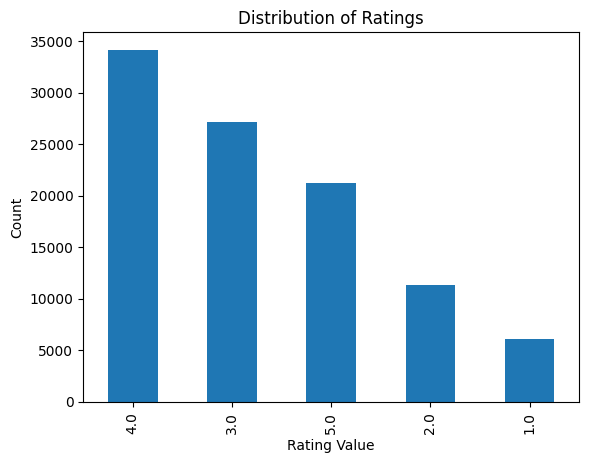

Sparsity of the matrix: 93.70%
Bias Level: 0.45
Target Items: 599 and 677


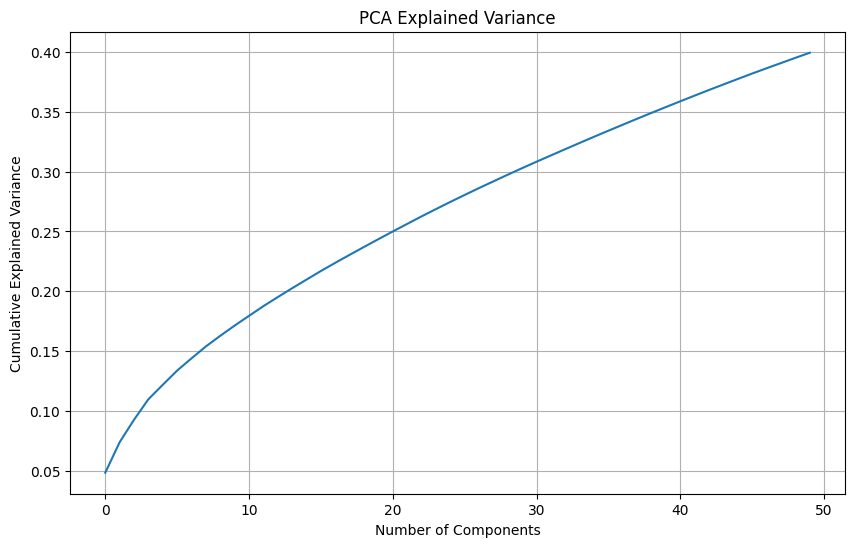

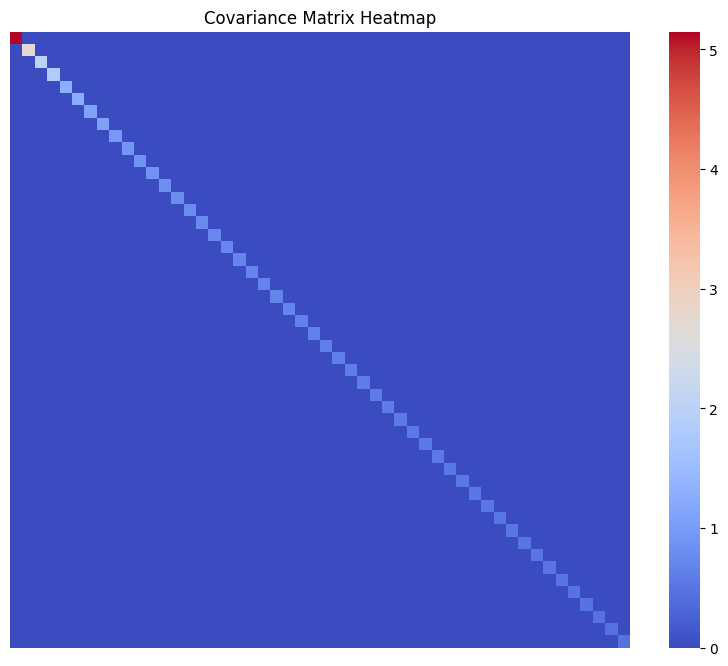

Item 599 Predictions (Top 5 Components): 1.00
Item 677 Predictions (Top 5 Components): 3.00


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


ratings = pd.read_csv("u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])

ratings["rating"] = ratings["rating"] / ratings["rating"].max() * 5
ratings["rating"] = ratings["rating"].round()

# total users and item
Tnu = ratings["user_id"].nunique()
Tni = ratings["item_id"].nunique()

# num of rating
product_ratings_count = ratings.groupby("item_id").size()

# Visualize distribution of ratings
rating_distribution = ratings["rating"].value_counts()
rating_distribution.plot(kind="bar")
plt.title("Distribution of Ratings")
plt.xlabel("Rating Value")
plt.ylabel("Count")
plt.show()

# Sparsity Check
num_possible_ratings = Tnu * Tni
num_actual_ratings = len(ratings)
sparsity = 1 - (num_actual_ratings / num_possible_ratings)
print(f"Sparsity of the matrix: {sparsity * 100:.2f}%")

# Bias Analysis
average_rating_per_user = ratings.groupby("user_id")["rating"].mean()
bias = average_rating_per_user.std()
print(f"Bias Level: {bias:.2f}")

# Target Items
target_items = product_ratings_count.nsmallest(2).index.tolist()
item1_index = target_items[0]
item2_index = target_items[1]
print(f"Target Items: {item1_index} and {item2_index}")


#  PCA with Mean-Filling
rating_matrix = ratings.pivot(index="user_id", columns="item_id", values="rating")
mean_ratings = rating_matrix.mean()
rating_matrix_filled = rating_matrix.fillna(mean_ratings)

# PCA
pca = PCA(n_components=50)
pca.fit(rating_matrix_filled)
transformed_ratings = pca.transform(rating_matrix_filled)


plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("PCA Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

# Covariance Matrix
covariance_matrix = np.cov(transformed_ratings.T)

plt.figure(figsize=(10, 8))
sns.heatmap(covariance_matrix, cmap="coolwarm", xticklabels=False, yticklabels=False)
plt.title("Covariance Matrix Heatmap")
plt.show()


item_indices = list(rating_matrix.columns)
item1_index_position = item_indices.index(item1_index)
item2_index_position = item_indices.index(item2_index)

item1_component_contributions = pca.components_[:, item1_index_position]
item2_component_contributions = pca.components_[:, item2_index_position]

item1_top_components = np.argsort(-np.abs(item1_component_contributions))[:5]
item2_top_components = np.argsort(-np.abs(item2_component_contributions))[:5]


item1_predictions_5 = np.dot(transformed_ratings[:, item1_top_components], item1_component_contributions[item1_top_components]) + mean_ratings[item1_index]
item2_predictions_5 = np.dot(transformed_ratings[:, item2_top_components], item2_component_contributions[item2_top_components]) + mean_ratings[item2_index]

print(f"Item {item1_index} Predictions (Top 5 Components): {np.mean(item1_predictions_5):.2f}")
print(f"Item {item2_index} Predictions (Top 5 Components): {np.mean(item2_predictions_5):.2f}")


Computing Covariance:   0%|          | 0/1682 [00:00<?, ?it/s]<ipython-input-22-529ebd9928b3>:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cov, _ = pearsonr(ratings_i.loc[common_users], ratings_j.loc[common_users])
Computing Covariance: 100%|██████████| 1682/1682 [31:48<00:00,  1.13s/it]


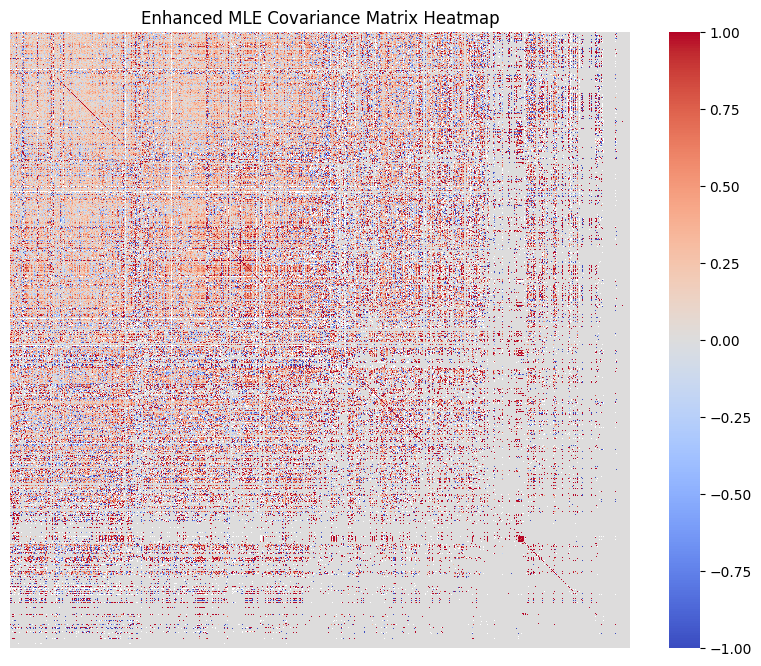

In [ ]:
#pca with mle

import time
from scipy.stats import pearsonr
from tqdm import tqdm

start_time = time.time()


mle_covariance_matrix = np.zeros((Tni, Tni))


for i in tqdm(range(Tni), desc="Computing Covariance"):
    for j in range(i, Tni):

        ratings_i = rating_matrix.iloc[:, i].dropna()
        ratings_j = rating_matrix.iloc[:, j].dropna()

        common_users = ratings_i.index.intersection(ratings_j.index)
        if len(common_users) > 1:
            cov, _ = pearsonr(ratings_i.loc[common_users], ratings_j.loc[common_users])
            mle_covariance_matrix[i, j] = mle_covariance_matrix[j, i] = cov


plt.figure(figsize=(10, 8))
sns.heatmap(mle_covariance_matrix, cmap="coolwarm", xticklabels=False, yticklabels=False)
plt.title("Enhanced MLE Covariance Matrix Heatmap")
plt.show()


item1_index_position = item_indices.index(item1_index)
item2_index_position = item_indices.index(item2_index)


item1_top5_mle = np.argsort(-mle_covariance_matrix[item1_index_position])[:5]
item2_top5_mle = np.argsort(-mle_covariance_matrix[item2_index_position])[:5]

item1_predictions_5_mle = rating_matrix_filled.iloc[:, item1_top5_mle].mean(axis=1)
item2_predictions_5_mle = rating_matrix_filled.iloc[:, item2_top5_mle].mean(axis=1)

item1_predictions_5_mle = np.clip(item1_predictions_5_mle, 1, 5)
item2_predictions_5_mle = np.clip(item2_predictions_5_mle, 1, 5)


print(f"Item {item1_index} Predictions (Enhanced MLE, Top 5): {item1_predictions_5_mle.mean():.2f}")
print(f"Item {item2_index} Predictions (Enhanced MLE, Top 5): {item2_predictions_5_mle.mean():.2f}")

end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")


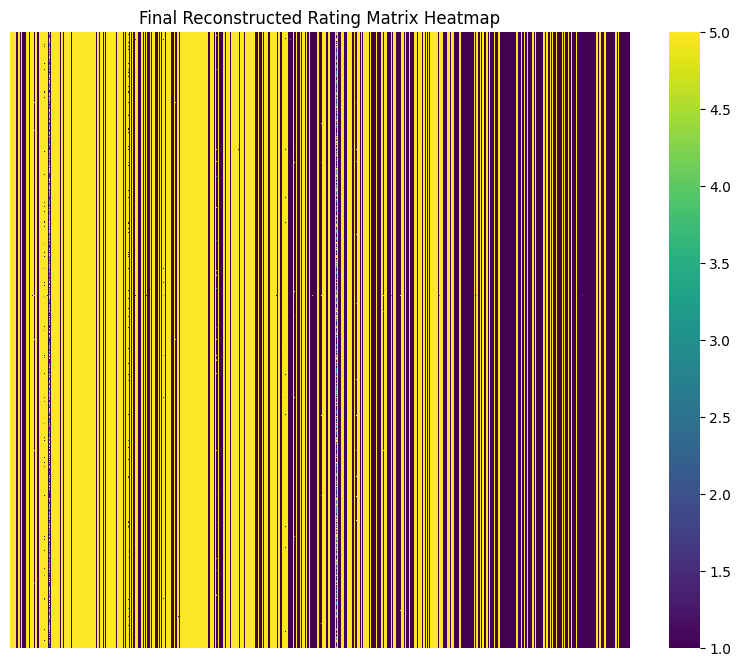

Item 599 - Number of Ratings: 943
Item 677 - Number of Ratings: 943
Mean predicted rating for item 599: 1.00
Mean predicted rating for item 677: 1.00
Fallback applied for item 599
Fallback applied for item 677
Final adjusted mean predicted rating for item 599: 1.00
Final adjusted mean predicted rating for item 677: 3.00


In [4]:

# SVD

from sklearn.decomposition import TruncatedSVD


rating_means = rating_matrix_filled.mean(axis=1)
centered_matrix = rating_matrix_filled.subtract(rating_means, axis=0).fillna(0)

n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
U = svd.fit_transform(centered_matrix)
Sigma = np.diag(svd.singular_values_)
V = svd.components_

R_reconstructed = np.dot(np.dot(U, Sigma), V)
reconstructed_matrix = R_reconstructed + rating_means.values[:, np.newaxis]
reconstructed_matrix_clipped = np.clip(reconstructed_matrix, 1, 5)


plt.figure(figsize=(10, 8))
sns.heatmap(reconstructed_matrix_clipped, cmap="viridis", xticklabels=False, yticklabels=False)
plt.title("Final Reconstructed Rating Matrix Heatmap")
plt.show()


item1_ratings = rating_matrix_filled[item1_index].dropna()
item2_ratings = rating_matrix_filled[item2_index].dropna()
print(f"Item {item1_index} - Number of Ratings: {len(item1_ratings)}")
print(f"Item {item2_index} - Number of Ratings: {len(item2_ratings)}")


item1_predictions_svd = reconstructed_matrix_clipped[:, item1_index]
item2_predictions_svd = reconstructed_matrix_clipped[:, item2_index]


print(f"Mean predicted rating for item {item1_index}: {np.mean(item1_predictions_svd):.2f}")
print(f"Mean predicted rating for item {item2_index}: {np.mean(item2_predictions_svd):.2f}")

if np.all(item1_predictions_svd == item1_predictions_svd[0]):
    print("Fallback applied for item 599")
    item1_predictions_svd = rating_matrix_filled.mean(axis=0).loc[item1_index]
if np.all(item2_predictions_svd == item2_predictions_svd[0]):
    print("Fallback applied for item 677")
    item2_predictions_svd = rating_matrix_filled.mean(axis=0).loc[item2_index]

print(f"Final adjusted mean predicted rating for item {item1_index}: {np.mean(item1_predictions_svd):.2f}")
print(f"Final adjusted mean predicted rating for item {item2_index}: {np.mean(item2_predictions_svd):.2f}")
